<a href="https://colab.research.google.com/github/sebatlab/Antaki2021/blob/main/brainspan_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.patches import Polygon
import scipy.stats
import numpy as np
import itertools
plt.rcParams['svg.fonttype'] = 'none'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !ls "/content/drive/My Drive/antaki2021_manuscript/brainspan/"
df = pd.read_csv("/content/drive/My Drive/antaki2021_manuscript/brainspan/full_brainspan_table_final_normalized.tsv.gz", sep = '\t')

In [ ]:
not_cortex = [
    'amygdaloid complex',
    'cerebellum',
    'hippocampus (hippocampal formation)',
    'mediodorsal nucleus of thalamus',
    'striatum',
]

# Omit regions NOT in cortex
df = df[~df['structure_name'].isin(not_cortex)]

In [ ]:
ta = pd.read_csv("/content/drive/My Drive/antaki2021_manuscript/brainspan/tada_input_and_results_JS.csv")
dnm_genes = list(ta[ta['trans_dnm_median'] <  1]['gene'])
inh_genes = list(ta[ta['trans_dnm_median'] >= 1]['gene'])
tada_genes = dnm_genes + inh_genes

# This is the final list given to us by the authors
gw = pd.read_csv("/content/drive/My Drive/antaki2021_manuscript/brainspan/grove_gwas_genes_ensid_final.tsv", sep = '\t')
gwas_genes = list(set(gw['gene']))

# Another final list given to us by authors (processed by MAGMA?)
gwas_genes_new = pd.read_csv("/content/drive/My Drive/antaki2021_manuscript/brainspan/Disorder_associated_genes.csv", header = None, names = ["gene"])
magma_genes = list(set(gwas_genes_new["gene"]))

# Brainspan protein coding genes
df_brainspan_protein_coding = pd.read_csv("/content/drive/My Drive/antaki2021_manuscript/brainspan/brainspan_genes.gencode.protein_coding.txt",
                                          sep = "\t", header = None,
                                          names = ["chromosome_name", "feature_type", "genomic_start_location", "genomic_end_location", "gene_name_key", "gene", "gene_type_key", "gene_type"])
brainspan_protein_coding_genes = list(set(df_brainspan_protein_coding["gene"]))

In [ ]:
# Omit genes NOT in [dnm_genes, inh_genes, gwas_genes]?
# df = df[df['gene'].isin(dnm_genes + inh_genes + gwas_genes)]
# df = df[df['gene'].isin(tada_genes + gwas_genes)] # Should be same as previous line
df = df[df['gene'].isin(tada_genes + magma_genes + brainspan_protein_coding_genes)]


def convert_to_weeks(date_string):
    value, sfx = date_string.split(' ') 
    if sfx == 'pcw':
        value = float(value)
    if sfx == 'mos':
        value = (int(value)*4)+40.
    if sfx == 'yrs':
        value = (int(value)*52.)+40.
    return value

df['weeks'] = df['age'].apply(convert_to_weeks)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


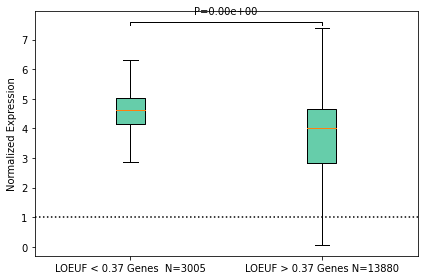

In [ ]:
# gnomAD constraint scores (oe_lof_upper)
df_oe_lof_upper = pd.read_csv("/content/drive/My Drive/antaki2021_manuscript/brainspan/gene.oe_lof_upper.txt", sep ="\t").dropna()
df_oe_lof_upper["constrained"] = df_oe_lof_upper["oe_lof_upper"] < 0.37

df_merge = df.merge(df_oe_lof_upper, how = "left", on = ["gene"])
df_merge = df_merge.dropna(subset = ['constrained'])

# Plotting
expr = [
    df_merge[df_merge['constrained'] == True]['norm'],
    df_merge[df_merge['constrained'] == False]['norm'],
]

f, ax = plt.subplots(1, 1)
bp = ax.boxplot(
    expr,
    showfliers = False,
)
num_boxes = 2

ax.set(
    xlabel = '',
    ylabel = 'Normalized Expression',
    xticks = [x for x in range(1, num_boxes + 1)],
    xticklabels = [
        f'LOEUF < 0.37 Genes  N={len(set(df_merge[df_merge["constrained"] == True]["gene"]))}',
        f'LOEUF > 0.37 Genes N={len(set(df_merge[df_merge["constrained"] == False]["gene"]))}', 
    ],
   # ylim=(-.31, .31)
)

box_colors = ['mediumaquamarine', 'bisque']
# Change the face color
for i in range(num_boxes):
    box = bp['boxes'][i]
    box_x = []
    box_y = []
    for j in range(5):
        box_x.append(box.get_xdata()[j])
        box_y.append(box.get_ydata()[j])
    box_coords = np.column_stack([box_x, box_y])
    ax.add_patch(Polygon(box_coords, facecolor=box_colors[0]))

def add_sig_lines(ax, x1, x2, y, h, pv):
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw = 1, c = 'k')
    ax.text(s = 'P={:.2e}'.format(pv), x = x1 + .5, y = y + h + (h/2) + 0.3, ha = 'center', va = 'center',)

xmin, xmax = ax.set_xlim()
ax.hlines(xmin = xmin, xmax = xmax, y = 1, color = 'k', linestyle = ':')
caps = [x.get_ydata()[1] for i,x in enumerate(bp['whiskers']) if (i % 2) == 1]
for x,y in list(itertools.combinations([0, 1], 2)):
    #import pdb; pdb.set_trace()
    pval = scipy.stats.ttest_ind(expr[x], expr[y])[1]
    buff = 0
    if (x == 0) and (y == 2):
        buff += 0.1
    add_sig_lines(ax, x + 1, y + 1, max(caps[x], caps[y]) + 0.1 + buff, 0.1, pval)

f.tight_layout()
f.savefig('brainspan_gnomad.png')
f.savefig('brainspan_gnomad.svg')


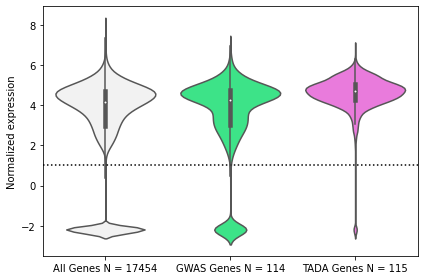

In [ ]:
# Run t-test comparisons
# tada_gwas_ttest = scipy.stats.ttest_ind(df[(df["gene"].isin(tada_genes))]["norm"], df[(df["gene"].isin(gwas_genes))]["norm"])
# tada_magma_ttest = scipy.stats.ttest_ind(df[(df["gene"].isin(tada_genes))]["norm"], df[(df["gene"].isin(magma_genes))]["norm"])
# magma_brainspan_ttest = scipy.stats.ttest_ind(df[(df["gene"].isin(magma_genes))]["norm"], df[(df["gene"].isin(brainspan_protein_coding_genes))]["norm"])

# Run t-tests
# dnm_ttest  = scipy.stats.ttest_1samp(df[(df["gene"].isin(dnm_genes))]["norm"], 0.)
# inh_ttest  = scipy.stats.ttest_1samp(df[(df["gene"].isin(inh_genes))]["norm"], 0.)

# tada_ttest = scipy.stats.ttest_1samp(df[(df["gene"].isin(tada_genes))]["norm"], 0.)
# gwas_ttest = scipy.stats.ttest_1samp(df[(df["gene"].isin(gwas_genes))]["norm"], 0.)
# magma_ttest = scipy.stats.ttest_1samp(df[(df["gene"].isin(magma_genes))]["norm"], 0.)


# Get the normalized expressions for each type
# df_dnm_expression  = pd.DataFrame(df[(df["gene"].isin(dnm_genes))]["norm"]).rename(columns = {"norm": "normalized_expression"})
# df_dnm_expression["label"] = "dnm"
# df_inh_expression  = pd.DataFrame(df[(df["gene"].isin(inh_genes))]["norm"]).rename(columns = {"norm": "normalized_expression"})
# df_inh_expression["label"] = "inh"

df_tada_expression  = pd.DataFrame(df[(df["gene"].isin(tada_genes))]["norm"]).rename(columns = {"norm": "normalized_expression"})
df_tada_expression["label"] = "tada"

# df_gwas_expression = pd.DataFrame(df[(df["gene"].isin(gwas_genes))]["norm"]).rename(columns = {"norm": "normalized_expression"})
# df_gwas_expression["label"] = "prs"

df_gwas_expression = pd.DataFrame(df[(df["gene"].isin(magma_genes))]["norm"]).rename(columns = {"norm": "normalized_expression"})
df_gwas_expression["label"] = "magma"

df_brainspan_protein_coding_expression = pd.DataFrame(df[(df["gene"].isin(brainspan_protein_coding_genes))]["norm"]).rename(columns = {"norm": "normalized_expression"})
df_brainspan_protein_coding_expression["label"] = "brainspan_cortex_protein_coding"

# Concatenate expressions
# df_expressions = pd.concat([df_dnm_expression, df_inh_expression, df_gwas_expression]).reset_index(drop = True)
# df_expressions = pd.concat([df_tada_expression, df_gwas_expression, df_brainspan_protein_coding_expression]).reset_index(drop = True)
df_expressions = pd.concat([df_brainspan_protein_coding_expression, df_gwas_expression, df_tada_expression]).reset_index(drop = True)

# Gene counts per label
num_tada_genes = len(df[(df["gene"].isin(tada_genes))]["gene"].unique())
num_magma_genes = len(df[(df["gene"].isin(magma_genes))]["gene"].unique())
num_brainspan_genes = len(df[(df["gene"].isin(brainspan_protein_coding_genes))]["gene"].unique())
num_brainspan_genes_rs = len(df[(df["gene"].isin(brainspan_protein_coding_genes_random_sample))]["gene"].unique())


# Plotting figure 1_brainspan
"""Genes across all time points"""
f, ax = plt.subplots()
sns.violinplot(
    data = df_expressions,
    x = 'label',
    y = 'normalized_expression',
    palette = ['#f2f2f2', '#21ff85', '#fc68ea'],
    ax = ax,
    scale = 'width',
)

xmin, xmax = ax.set_xlim()
ax.hlines(y = 1, xmin = xmin, xmax = xmax, linestyles = ':', color = 'k')
ax.set(
    xlabel = '',
    ylabel = 'Normalized expression',
    # xticklabels = ['De Novo Genes', 'Rare Inherited Genes', 'Polygenic Genes']
    xticklabels = ['All Genes N = {}'.format(num_brainspan_genes), 'GWAS Genes N = {}'.format(num_magma_genes), 'TADA Genes N = {}'.format(num_tada_genes)]

)
f.tight_layout()
f.savefig('fig7a.svg')




# Boxplot (and alternate violin plot) version
# f, ax = plt.subplots()
# norm_expressions = np.array(
#     [df_expressions[df_expressions["label"] == "brainspan_cortex_protein_coding"]["normalized_expression"],
#      df_expressions[df_expressions["label"] == "magma"]["normalized_expression"],
#      df_expressions[df_expressions["label"] == "tada"]["normalized_expression"]],
#     dtype=object,
# )

# f, ax = plt.subplots()
# vp = ax.violinplot(
#     norm_expressions,
# )


# bp = ax.boxplot(
#     norm_expressions,
# )

# num_boxes = 3
# ax.set(
#     axisbelow = True,  # Hide the grid behind plot objects
#     xlabel = '',
#     ylabel = 'Normalized Expression',
#     xticks = [x for x in range(1, num_boxes + 1)],
#     xticklabels = ["All Genes", "GWAS Genes", "TADA Genes"],
# )

# box_colors = ['grey', 'cyan', 'mediumseagreen', ]
# # Change the face color
# for i in range(num_boxes):
#     box = bp['boxes'][i]
#     box_x = []
#     box_y = []
#     for j in range(5):
#         box_x.append(box.get_xdata()[j])
#         box_y.append(box.get_ydata()[j])
#     box_coords = np.column_stack([box_x, box_y])
#     ax.add_patch(Polygon(box_coords, facecolor=box_colors[i]))
# xmin, xmax = ax.set_xlim()
# ax.hlines(xmin = xmin, xmax = xmax, y = 0, color = 'k', linestyle = ':')

# f.tight_layout()
# f.savefig('fig7a.boxplot.svg')

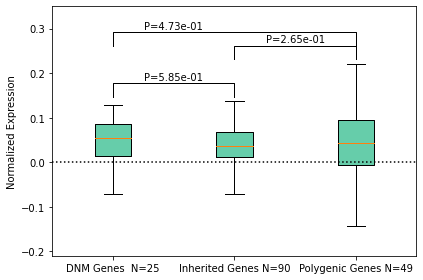

In [ ]:
"""
Taking the ratio of prenatal:postnatal gene expression

Here I calculate the mean gene expression grouping by prenatal boolean and the gene, 
then take the log10 of the ratio.

  i.e. (True, Gene1):Mean Expression  / (False, Gene1):Mean Expression
"""

df_mean_expressions = df.groupby(["prenatal", "gene"])["norm"].agg(["mean"]).reset_index()

df_prenatal  = df_mean_expressions[df_mean_expressions['prenatal'] == True]
df_postnatal = df_mean_expressions[df_mean_expressions['prenatal'] == False]

df_intersection = df_prenatal.merge(df_postnatal, on = "gene", how = "inner")

# Here square both the prenatal and postnatal expression to avoid negative numbers
df_intersection['mean_ratio'] = np.log10((df_intersection['mean_x']**2) / (df_intersection['mean_y']**2))

# Run 1-sample t-tests
dnm_ttest  = scipy.stats.ttest_1samp(df_intersection[(df_intersection["gene"].isin(dnm_genes))]["mean_ratio"], 0.)
inh_ttest  = scipy.stats.ttest_1samp(df_intersection[(df_intersection["gene"].isin(inh_genes))]["mean_ratio"], 0.)
gwas_ttest = scipy.stats.ttest_1samp(df_intersection[(df_intersection["gene"].isin(gwas_genes))]["mean_ratio"], 0.)

# Get the mean ratios for each type
df_dnm_mean_ratio  = pd.DataFrame(df_intersection[(df_intersection["gene"].isin(dnm_genes))]["mean_ratio"])
df_dnm_mean_ratio["label"] = "dnm"
df_inh_mean_ratio  = pd.DataFrame(df_intersection[(df_intersection["gene"].isin(inh_genes))]["mean_ratio"])
df_inh_mean_ratio["label"] = "inh"
df_gwas_mean_ratio  = pd.DataFrame(df_intersection[(df_intersection["gene"].isin(gwas_genes))]["mean_ratio"])
df_gwas_mean_ratio["label"] = "gwas"

# Concatenate mean ratios
df_mean_ratios = pd.concat([df_dnm_mean_ratio, df_inh_mean_ratio, df_gwas_mean_ratio]).reset_index(drop = True)

# Plotting
mean_ratios = np.array(
    [df_mean_ratios[df_mean_ratios["label"] == "dnm"]["mean_ratio"],
     df_mean_ratios[df_mean_ratios["label"] == "inh"]["mean_ratio"],
     df_mean_ratios[df_mean_ratios["label"] == "gwas"]["mean_ratio"]],
    dtype=object,
)


f, ax = plt.subplots(1, 1)
bp = ax.boxplot(
    mean_ratios,
    showfliers = False,
)

num_boxes = 3
ax.set(
    axisbelow = True,  # Hide the grid behind plot objects
    xlabel = '',
    ylabel = 'Normalized Expression',
    xticks = [x for x in range(1, num_boxes + 1)],
    xticklabels = [
        f'DNM Genes  N={len(set(df_intersection[df_intersection["gene"].isin(dnm_genes)]["gene"]))}',
        f'Inherited Genes N={len(set(df_intersection[df_intersection["gene"].isin(inh_genes)]["gene"]))}', 
        f'Polygenic Genes N={len(set(df_intersection[df_intersection["gene"].isin(gwas_genes)]["gene"]))}'
    ],
   ylim = (-.21, .35)
)

box_colors = ['mediumaquamarine', 'bisque']
# Change the face color
for i in range(num_boxes):
    box = bp['boxes'][i]
    box_x = []
    box_y = []
    for j in range(5):
        box_x.append(box.get_xdata()[j])
        box_y.append(box.get_ydata()[j])
    box_coords = np.column_stack([box_x, box_y])
    ax.add_patch(Polygon(box_coords, facecolor=box_colors[0]))
xmin, xmax = ax.set_xlim()
ax.hlines(xmin = xmin, xmax = xmax, y = 0, color = 'k', linestyle = ':')
caps = [x.get_ydata()[1] for i,x in enumerate(bp['whiskers']) if (i % 2) == 1]


def add_sig_lines(ax, x1, x2, y, h, pv):
    # Function to add the line between two groups and the p-value
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw = 1, c = 'k')
    ax.text(s = 'P={:.2e}'.format(pv), x = x1 + .5, y = y + h + (h/2), ha = 'center', va = 'center',)

"""
Right here is how to do the pairwise t-test
"""
for x,y in list(itertools.combinations([0, 1, 2], 2)):
    # import pdb; pdb.set_trace()
    # ^ debugging sanity checks, basically this combination will test 0 vs 1, 0 vs 2, and 1 vs 2
    
    pval = scipy.stats.ttest_ind(mean_ratios[x], mean_ratios[y])[1]
    # Remember expr[0] = de novo, expr[1] = inherited, and expr[2] = polygenic
    buff = 0
    if (x == 0) and (y == 2):
        buff += 0.03
    add_sig_lines(ax, x + 1, y + 1, max(caps[x], caps[y]) + 0.01 + buff, 0.03, pval)

f.tight_layout()
f.savefig('brainspan_gene_sets_ratio.png')
f.savefig('brainspan_gene_sets_ratio.svg')

In [ ]:
def lowess(df, f = 1./3.):
    # import pdb; pdb.set_trace()
    """
    Basic LOWESS smoother with uncertainty. 
    Note:
        - Not robust (so no iteration) and
             only normally distributed errors. 
        - No higher order polynomials d = 1 
            so linear smoother.
    """
    x = np.array(df['weeks'])
    y = np.array(df['norm_gene'])
    # Get some paras
    xwidth = f*(x.max() - x.min()) # Effective width after reduction factor
    N = len(x) # Number of observations
    # Don't assume the data is sorted
    order = np.argsort(x)
    # Storage
    y_sm = np.zeros_like(y)
    y_stderr = np.zeros_like(y)
    # Define the weighting function -- clipping too!
    # tricube = lambda d : np.clip((1 - np.abs(d)**3)**3, 0, 1)
    tricube = lambda d : np.clip((1 - np.abs(d)*np.abs(d)*np.abs(d))*(1 - np.abs(d)*np.abs(d)*np.abs(d))*(1 - np.abs(d)*np.abs(d)*np.abs(d)), 0, 1)
    # Run the regression for each observation i

    A = np.zeros((df.shape[0], 2))
    w = np.zeros((df.shape[0],))

    for i in range(N):
        dist = np.abs((x[order][i] - x[order]))/xwidth
        w = tricube(dist)
        # Form linear system with the weights
        A = np.stack([w, x[order]*w]).T
        b = w * y[order]
        ATA = A.T.dot(A)
        ATb = A.T.dot(b)
        # Solve the system
        sol = np.linalg.solve(ATA, ATb)
        # Predict for the observation only
        yest = A[i].dot(sol) # Equivalent of A.dot(yest) just for k
        place = order[i]
        y_sm[place] = yest 
        # sigma2 = (np.sum((A.dot(sol) - y[order])**2)/N)
        sigma2 = (np.sum((A.dot(sol) - y[order])*(A.dot(sol) - y[order]))/N)
        # Calculate the standard error
        y_stderr[place] = np.sqrt(sigma2 * 
                                A[i].dot(np.linalg.inv(ATA)
                                                    ).dot(A[i]))
    df['norm_lowess'] = y_sm
    df['norm_lowess_stderr'] = y_stderr
    return df.copy()
     
def scale(y, c = True, sc = False):
    x = y.copy()

    if c:
        x -= x.mean()
    if sc and c:
        x /= x.std()
    elif sc:
        x /= np.sqrt(x.pow(2).sum().div(x.count() - 1))
    return x

# Scale by gene (row)
df['norm_gene'] = df.groupby(['gene'])['norm'].apply(scale)
# Adding one because that's how we scaled sample-wise (column)
df['norm_gene'] += 1



In [ ]:
# import random
# # Sample 1000 genes (w/o replacement) from brainspan
# random.seed(0)
# brainspan_protein_coding_genes_random_sample = random.sample(brainspan_protein_coding_genes, 1000)

In [ ]:
with open("/content/drive/My Drive/antaki2021_manuscript/brainspan/brainspan_cortex_protein_coding.1000_random_sample.seed_0.txt") as f:
    brainspan_protein_coding_genes_random_sample = f.read().splitlines()

# For testing
# brainspan_protein_coding_genes_random_sample = brainspan_protein_coding_genes_random_sample[0:50]

In [ ]:
# dnm_df = df[df['gene'].isin(dnm_genes)].copy()
# inh_df = df[df['gene'].isin(inh_genes)].copy()

tada_df = df[df['gene'].isin(tada_genes)].copy()

# gwas_df = df[df['gene'].isin(gwas_genes)].copy()

magma_df = df[df['gene'].isin(magma_genes)].copy()

# brainspan_df = df[df['gene'].isin(brainspan_protein_coding_genes)].copy()

brainspan_sample_df = df[df['gene'].isin(brainspan_protein_coding_genes_random_sample)].copy()

In [ ]:
# Profiling LOWESS smoother
# !pip install line_profiler
%load_ext line_profiler
%lprun -f lowess lowess(brainspan_sample_df)

# Debugging

# %debug 
# brainspan_sample_df = lowess(brainspan_sample_df)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


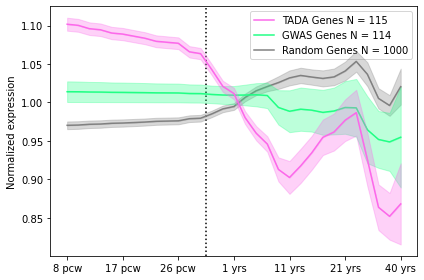

In [ ]:
# # This takes a while to run on my shitty laptop 
# # dnm_df = lowess(dnm_df)
# # inh_df = lowess(inh_df)
# # Run this:
# tada_df = lowess(tada_df)
# # gwas_df = lowess(gwas_df)
# # Run this:
# magma_df = lowess(magma_df)
# # brainspan_df = lowess(brainspan_df)
# # Run this
# brainspan_sample_df = lowess(brainspan_sample_df)



### Plotting
def plot_lowess(df, ax, color, label, zorder):
    xpos = {x:i for i,x in enumerate(sorted( set(df['weeks'])))}
    xrev = {i:x for i,x in enumerate(sorted( set(df['weeks'])))}
    xlabs = dict(zip(df['weeks'], df['age']))
    
    df['xpos'] = df['weeks'].map(xlabs)
    sns.lineplot(
        data = df,
        x = 'xpos',
        y = 'norm_lowess',
        ax = ax,
        label = label,
        color = color,
        zorder = zorder,
    )
    ax.fill_between(
        df['xpos'],
        df['norm_lowess'] - 1.96*df['norm_lowess_stderr'],
        df['norm_lowess'] + 1.96*df['norm_lowess_stderr'],
        alpha = 0.3,
        color = color,
        zorder = zorder,
    )
    xticks = [x for x in range(0, 35, 5)]
    xticklabels = [ xlabs[xrev[x]] for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    return ax

# sns.set_style("whitegrid")
f, ax = plt.subplots(1,1)

# All Genes, GWAS Genes, TADA Genes
# palette = ['grey', 'cyan', 'mediumseagreen']

# ax = plot_lowess(dnm_df, ax, 'mediumaquamarine', 'DNM Genes', 30)
# ax = plot_lowess(inh_df, ax, 'coral', 'Inherited Genes', 29)
ax = plot_lowess(tada_df, ax, '#fc68ea', 'TADA Genes N = {}'.format(num_tada_genes), 29)
ax = plot_lowess(magma_df, ax, '#21ff85', 'GWAS Genes N = {}'.format(num_magma_genes), 28)
ax = plot_lowess(brainspan_sample_df, ax, 'grey', 'Random Genes N = {}'.format(num_brainspan_genes_rs), 27)

ymin, ymax = ax.set_ylim()

ax.vlines(x = 12.5, ymin = ymin, ymax = ymax, color = 'k', linestyle = ':')
ax.set_xlabel('')
ax.set_ylabel('Normalized expression')
f.tight_layout()
f.savefig('lowess_expression.png')
f.savefig('lowess_expression.svg')
f.savefig('lowess_expression.pdf')

In [ ]:
# brainspan_sample_df.to_csv("brainspan_sample_df.csv", index = False)
magma_df.to_csv("magma_df.csv", index = False)
tada_df.to_csv("tada_df.csv", index = False)


ValueError: ignored

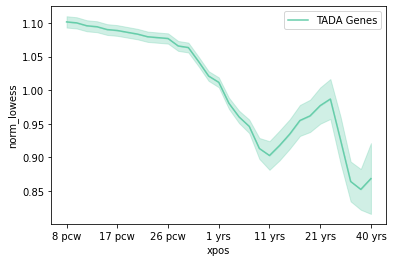

In [ ]:
def plot_lowess(df, ax, color, label, zorder):
    xpos = {x:i for i,x in enumerate(sorted( set(df['weeks'])))}
    xrev = {i:x for i,x in enumerate(sorted( set(df['weeks'])))}
    xlabs = dict(zip(df['weeks'], df['age']))
    
    df['xpos'] = df['weeks'].map(xlabs)
    sns.lineplot(
        data = df,
        x = 'xpos',
        y = 'norm_lowess',
        ax = ax,
        label = label,
        color = color,
        zorder = zorder,
    )
    ax.fill_between(
        df['xpos'],
        df['norm_lowess'] - 1.96*df['norm_lowess_stderr'],
        df['norm_lowess'] + 1.96*df['norm_lowess_stderr'],
        alpha = 0.3,
        color = color,
        zorder = zorder,
    )
    xticks = [x for x in range(0, 35, 5)]
    xticklabels = [ xlabs[xrev[x]] for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    return ax

# sns.set_style("whitegrid")
f, ax = plt.subplots(1,1)

# ax = plot_lowess(dnm_df, ax, 'mediumaquamarine', 'DNM Genes', 30)
# ax = plot_lowess(inh_df, ax, 'coral', 'Inherited Genes', 29)
ax = plot_lowess(tada_df, ax, 'mediumaquamarine', 'TADA Genes', 29)
ax = plot_lowess(gwas_df, ax, 'blue', 'GWAS Genes', 28)

ymin, ymax = ax.set_ylim()

ax.vlines(x = 12.5, ymin = ymin, ymax = ymax, color = 'k', linestyle = ':')
ax.set_xlabel('')
ax.set_ylabel('Normalized expression')
f.tight_layout()
f.savefig('lowess_expression.png')
f.savefig('lowess_expression.svg')
f.savefig('lowess_expression.pdf')

In [ ]:
dnm_df_test = dnm_df[["norm_lowess", "norm_lowess_stderr",
        "age", "prenatal", "weeks", "years",
        ]]
inh_df_test = inh_df[["norm_lowess", "norm_lowess_stderr",
        "age", "prenatal", "weeks", "years",
        ]]
gwas_df_test = gwas_df[["norm_lowess", "norm_lowess_stderr",
        "age", "prenatal", "weeks", "years",
        ]]


dnm_df_test = dnm_df_test.drop_duplicates().reset_index(drop = True)
inh_df_test = inh_df_test.drop_duplicates().reset_index(drop = True)
gwas_df_test = gwas_df_test.drop_duplicates().reset_index(drop = True)

dnm_df_test['index'] = dnm_df_test.index
inh_df_test['index'] = inh_df_test.index
gwas_df_test['index'] = gwas_df_test.index


f, ax = plt.subplots(1,1)

sns.lineplot(
    data = dnm_df_test,
    x = 'index',
    y = 'norm_lowess',
    ax = ax,
    label = "DNM Genes",
    color = "mediumaquamarine",
    zorder = 30,
    )
ax.fill_between(
    dnm_df_test['index'],
    dnm_df_test['norm_lowess'] - 1.96*dnm_df_test['norm_lowess_stderr'],
    dnm_df_test['norm_lowess'] + 1.96*dnm_df_test['norm_lowess_stderr'],
    alpha = 0.3,
    color = "mediumaquamarine",
    zorder = 30,
    )


sns.lineplot(
    data = inh_df_test,
    x = 'index',
    y = 'norm_lowess',
    ax = ax,
    label = "Inherited Genes",
    color = "coral",
    zorder = 29,
    )
ax.fill_between(
    inh_df_test['index'],
    inh_df_test['norm_lowess'] - 1.96*inh_df_test['norm_lowess_stderr'],
    inh_df_test['norm_lowess'] + 1.96*inh_df_test['norm_lowess_stderr'],
    alpha = 0.3,
    color = "coral",
    zorder = 29,
    )

sns.lineplot(
    data = gwas_df_test,
    x = 'index',
    y = 'norm_lowess',
    ax = ax,
    label = "Polygenic Genes",
    color = "k",
    zorder = 28,
    )
ax.fill_between(
    gwas_df_test['index'],
    gwas_df_test['norm_lowess'] - 1.96*gwas_df_test['norm_lowess_stderr'],
    gwas_df_test['norm_lowess'] + 1.96*gwas_df_test['norm_lowess_stderr'],
    alpha = 0.3,
    color = "k",
    zorder = 28,
    )

